In [ ]:
from google.colab import files
files.upload()

Saving train.zip to train.zip


{'train.zip': b'PK\x03\x04\n\x00\x00\x00\x00\x00f\x8c\xe6P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00train/PK\x03\x04\x14\x00\x00\x00\x08\x00\x1a\xb6\xa3N^V:\xfd\xab\x0c\x00\x00\x8b\r\x00\x00\x13\x00\x00\x00train/lld_25097.jpg\x9d\x96gT\xd3\xdb\x9a\xc6\xff!\xa1\x05\x14\x08Ep(J\xa4\x1c\x8a\x88\x88\x02R\x04\xa4K\x8d\x18:\x07\x10\xf1\x10\x10\x91"E\x08R\x95\x16!\x10A@\x8e@Pi9\x08\x18\x85P\xa4\xa3H\x91\x12z\t\xbdH\r\x100\x90\x81\xbb\xe6\xcc\xcc\x87\xbb\xd6\xdc;\xcf^\xcf^{\xad\xf7\xdd\xe5\xb7\xdf\x0f{3\x86\x18S\x00\xb7\xb1\xbe\x91>\x00\x02\x01\x00\xe8\xb8\x01\x8cQ@\x17\x003\x9d\xe8\xa4\x07\x1f\x0b\xc2\x029\x11\x1b\x0b\x0b3\x0b;\x1b\x14\xca\xce\xc6\xce\x0e\xe5\xe4\xe2\x84r\x9c\xe6`g?\xc5s\xea4\x1777\x0f7\x94\x13\xc6\x0b\xe3\xe6=\x1es\x9f,\x02:\x99\t\x86\xb0\x1dO\xe4\xe6`\xe7\xe0\xfe\xb7\xc5h\x00x\xd8\x80\x08 \x02\x0c\x12\x07\x98x@`\x1e\x10\xa3\x19\x10;>\'3\xe8\x1f\x02\xfeK &0\x84\x99\x85\x95\x8d\x1d\xcaq\x9cP\xc5\r0\x1d\xef\xcd\x04\x0133C \xc7\xd1\xb0\xe38\x00\xe1a\x86\x9

In [ ]:
!unzip train.zip

Archive:  train.zip
   creating: train/
  inflating: train/lld_25097.jpg     
  inflating: train/lld_26738.jpg     


In [ ]:
import numpy as np
import pandas as pd
import os

path = 'train' #Klasör yolu
picture_dir= os.listdir(path) #klasör içerisindeki dosya listesi
len(picture_dir) #klasör içerisindeki dosya sayısı

2

In [ ]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import os

picture_count = 2  #len(PIC_DIR) komutuna göre değişir.
width = 128
height = 128
   
pictures = []
for picture_file in tqdm(os.listdir(path)[:picture_count]):
    picture = Image.open(path + '/'  '/' + picture_file)
    print(picture_file)
    width,height=picture.size
    print(width,height)
    max_size = (128, 128) 
    picture.thumbnail(max_size) #Resimin yeni boyutu
    pictures.append(np.uint8(picture))
    
pictures = np.array(pictures) / 255
pictures.shape #images boyutsal şeklini gösterir.

100%|██████████| 2/2 [00:00<00:00, 83.02it/s]

lld_25097.jpg
128 128
lld_26738.jpg
128 128


(2, 128, 128, 3)

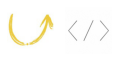

In [ ]:
from matplotlib import pyplot as plt

#Eğitilmek için alınan resimleri gösterir.
plt.figure(1, figsize=(5, 5))
for i in range(2):
    plt.subplot(5, 5, i+1)
    plt.imshow(pictures[i])
    plt.axis('off')
plt.show()

In [ ]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

latent_dim = 32
channels = 3

#Generator ağ oluşturan fonksiyon
def create_generator():
    gen_input = Input(shape=(latent_dim, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(channels, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

#Discriminator ağ oluşturan fonksiyon
def create_discriminator():
    disc_input = Input(shape=(height, width, channels))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator

Using TensorFlow backend.


In [ ]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False #discriminator eğitime kapalıdır.

# Gan modelinin oluşturulması
gan_input = Input(shape=(latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
import time

iters = 5000
batch_size = 13

result_dir = 'result'
file_path = '%s/generated_%d.png'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

control_size_sqrt = 1
control_vectors = np.random.normal(size=(control_size_sqrt**2, latent_dim)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated = generator.predict(latent_vectors)
    
    real = pictures[start:start + batch_size]
    combined_pictures = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size-11, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_pictures, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > pictures.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gang.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_picture = np.zeros((width * control_size_sqrt, height * control_size_sqrt, channels))
        control_generated = generator.predict(control_vectors)
        for i in range(control_size_sqrt ** 2):
            x_off = i % control_size_sqrt
            y_off = i // control_size_sqrt
            control_picture[x_off * width:(x_off + 1) * width, y_off * height:(y_off + 1) * height, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_picture * 255))
        im.save(file_path % (result_dir, images_saved))
        images_saved += 1

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50/5000: d_loss: 0.4247,  a_loss: 0.1933.  (0.9 sec)
100/5000: d_loss: 0.4647,  a_loss: 0.3055.  (0.9 sec)
150/5000: d_loss: 0.4371,  a_loss: 0.2693.  (0.9 sec)
200/5000: d_loss: 0.4188,  a_loss: 0.1769.  (0.8 sec)
250/5000: d_loss: 0.4618,  a_loss: 0.1373.  (0.8 sec)
300/5000: d_loss: 0.4261,  a_loss: 0.1561.  (0.9 sec)
350/5000: d_loss: 0.4365,  a_loss: 0.2028.  (0.8 sec)
400/5000: d_loss: 0.4324,  a_loss: 0.1515.  (0.9 sec)
450/5000: d_loss: 0.4103,  a_loss: 0.1866.  (0.8 sec)
500/5000: d_loss: 0.4354,  a_loss: 0.1901.  (0.9 sec)
550/5000: d_loss: 0.4596,  a_loss: 0.2382.  (0.8 sec)
600/5000: d_loss: 0.4418,  a_loss: 0.0389.  (0.9 sec)
650/5000: d_loss: 0.4337,  a_loss: 0.2134.  (0.9 sec)
700/5000: d_loss: 0.4259,  a_loss: 0.2068.  (0.9 sec)
750/5000: d_loss: 0.4365,  a_loss: 0.1899.  (0.9 sec)
800/5000: d_loss: 0.4388,  a_loss: 0.2084.  (0.9 sec)
850/5000: d_loss: 0.4196,  a_loss: 0.2257.  (0.9 sec)
900/5000: d_loss: 0.4266,  a_loss: 0.2137.  (0.9 sec)
950/5000: d_loss: 0.4168,  a_

In [ ]:
!zip -r result_train.zip result

  adding: result/ (stored 0%)
  adding: result/generated_77.png (stored 0%)
  adding: result/generated_71.png (stored 0%)
  adding: result/generated_85.png (stored 0%)
  adding: result/generated_61.png (stored 0%)
  adding: result/generated_20.png (stored 0%)
  adding: result/generated_62.png (stored 0%)
  adding: result/generated_30.png (stored 0%)
  adding: result/generated_47.png (stored 0%)
  adding: result/generated_2.png (deflated 22%)
  adding: result/generated_86.png (stored 0%)
  adding: result/generated_38.png (stored 0%)
  adding: result/generated_10.png (stored 0%)
  adding: result/generated_42.png (stored 0%)
  adding: result/generated_54.png (stored 0%)
  adding: result/generated_26.png (stored 0%)
  adding: result/generated_82.png (stored 0%)
  adding: result/generated_28.png (stored 0%)
  adding: result/generated_0.png (stored 0%)
  adding: result/generated_57.png (stored 0%)
  adding: result/generated_9.png (deflated 1%)
  adding: result/generated_53.png (stored 0%)
  

In [ ]:
files.download('result_train.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>